# DIVI Intensivregister

## What are we dealing with?
[It](https://www.intensivregister.de/#/intensivregister) is a php-generated page containing a table which lists many (not all?) German clinics in a column labeled *Klinikname*. Other columns are labeled *Kontakt* = contact info, *Bundesland* = federal state, [*ICU*](https://en.wikipedia.org/wiki/Intensive_care_unit) *low care*, *ICU high care*, [*ECMO*](https://en.wikipedia.org/wiki/Extracorporeal_membrane_oxygenation) and *Stand* = time stamp. The columns *ICU* and *ECMO* solely contain colored bubbles to illustrate the availability of these resources. The legends explains as follows:

* red = *Verfügbar* = ready
* yellow = *Begrenzt* = limited
* green = *Ausgelastet* = exhausted
* unavailable = unknown state




|  color        |  float  |
|:--------------|:-------:|
|  red          |   0.0   |
|  yellow       |   0.5   |
|  green        |   1.0   |
|  unavailable  |   NAN   |

## What to contribute?
The table only shows contemporary data as clinics submit their data (time stamp!). Aside to some statistics on that data -- what might be interesting to see is how it develops over time during the [COVID19](https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic) pandemic.

## Fetch data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scrape import scrape, divi

In [2]:
scrape_result = divi.to_dataframe()
scrape_result.describe()

,ICU low care,ICU high care,ECMO
count,1010.000000,1113.000000,227.000000
mean,0.804950,0.873765,0.685022
std,0.336241,0.278120,0.424520
min,0.000000,0.000000,0.000000
25%,0.500000,1.000000,0.500000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [3]:
df = scrape_result \
.drop_duplicates()
df.describe()

,ICU low care,ICU high care,ECMO
count,1010.000000,1113.000000,227.000000
mean,0.804950,0.873765,0.685022
std,0.336241,0.278120,0.424520
min,0.000000,0.000000,0.000000
25%,0.500000,1.000000,0.500000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


## Plot average values (per federal state)

Text(0, 0.5, 'federal state')

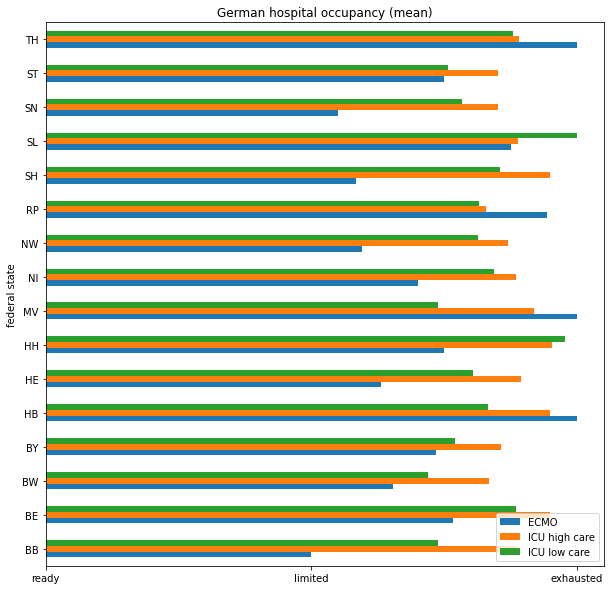

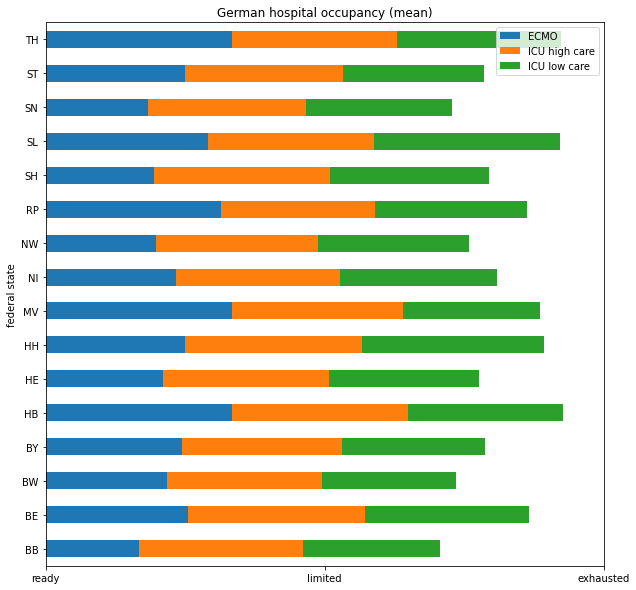

In [4]:
df \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=False, figsize=(10,10))
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 0.5, 1.0],["ready", "limited", "exhausted"])
plt.ylabel("federal state")
df \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO', 'ICU high care', 'ICU low care'], stacked=True, figsize=(10,10))
plt.title("German hospital occupancy (mean)")
plt.xticks([0.0, 1.5, 3.0],["ready", "limited", "exhausted"]) # 3x[0..1] = [0..3]
plt.ylabel("federal state")

So much for contemporary data.

# Historic data
Instead of downloading the data from DIVI we are going to use the old scrapes in `data/divi.tsv`:

In [5]:
#!git pull 2&>1 >/dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
df = pd \
.read_csv("data/divi.tsv", sep="\t") \
.replace({'NaN': 0.0, 'VERFUEGBAR': 1.0, 'BEGRENZT': 0.5, 'NICHT_VERFUEGBAR': 0.0}) \
.drop_duplicates()
df['Stand'] = pd.to_datetime(df['Stand'], format="%Y-%m-%d %H:%M:%S")
df = df[(df['Stand'] > '2019-12-31') & (df['Stand'] <= datetime.now())].set_index('Stand') \
.drop(columns='COVID-19 cases')

In [6]:
old = pd.read_csv("data/divi.recovered.tsv", sep="\t")\
.drop(columns='COVID-19 cases') \
.replace({'NRW': 'NW', '0': 'NW'})

old['Stand'] = pd.to_datetime(old['Stand'], format="%Y-%m-%d %H:%M:%S")

old = old[(old['Stand'] > '2019-12-31') & (old['Stand'] <= datetime.now())] \
.set_index('Stand') \
.drop_duplicates()

In [7]:
df = df.append(old).sort_index().drop_duplicates()
df.shape, old.shape

((3788, 5), (3655, 5))

In [10]:
import matplotlib.dates as mdates
from scrape import entorb

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
}

columns = ['ICU low care', 'ICU high care', 'ECMO']
federal_states = list(set(df['Bundesland']))
availability = dict()
num_clinics = dict()
infections = dict()
deaths = dict()

# plot each bundesland's total exhaustion
# but also keep each curve in dict bundesland_curves for later correlations
for federal_state in federal_states:
    clinics_curves_sum = None
    federal_state_clinics = list(set(df[df['Bundesland'] == federal_state]['Klinikname']))
    
    # apply padding to each clinic's curve
    for clinic in federal_state_clinics:
        # use resample() here because we want to correlate day-by-day later
        clinic_curve = df[df['Klinikname'] == clinic] \
        .drop(columns=['Bundesland', 'Klinikname']) \
        .resample("1D").sum()

        # is there something less clumsy from pandas?
        if clinics_curves_sum is None:
            clinics_curves_sum = clinic_curve
        else:
            clinics_curves_sum = clinics_curves_sum.add(clinic_curve, fill_value=0.5)
    
    availability[federal_state] = clinics_curves_sum
    num_clinics[federal_state] = len(federal_state_clinics)
    #infections[federal_state] = entorb.to_dataframe(federal_state)['Cases_New']
    deaths[federal_state] = entorb.to_dataframe(federal_state)['Deaths_New']
    deaths[federal_state].name = 'deaths'

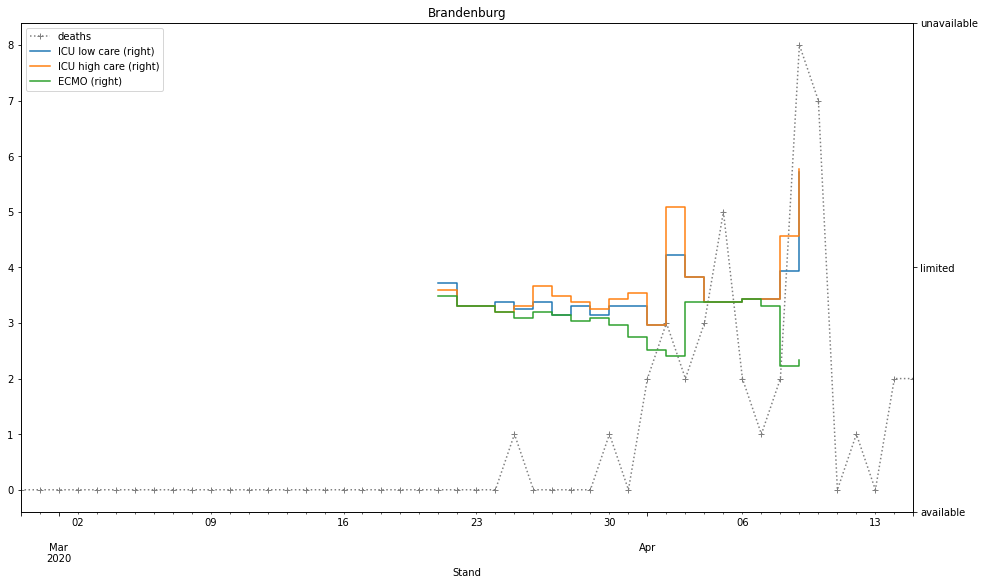

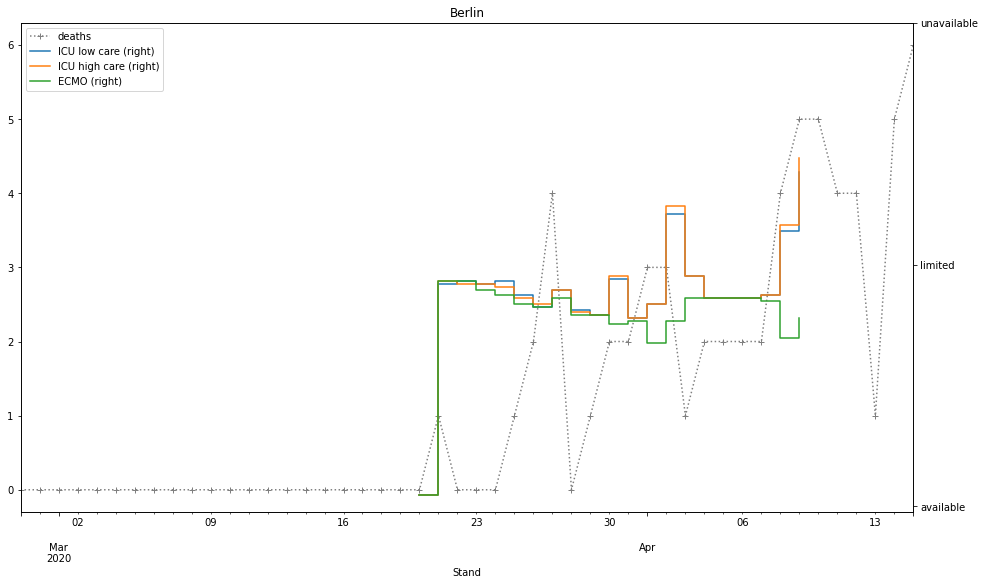

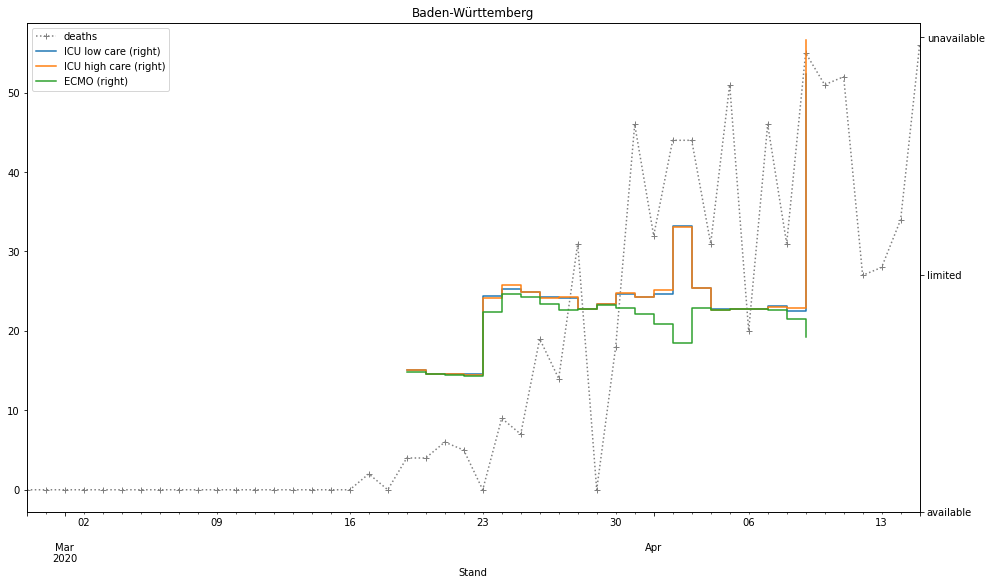

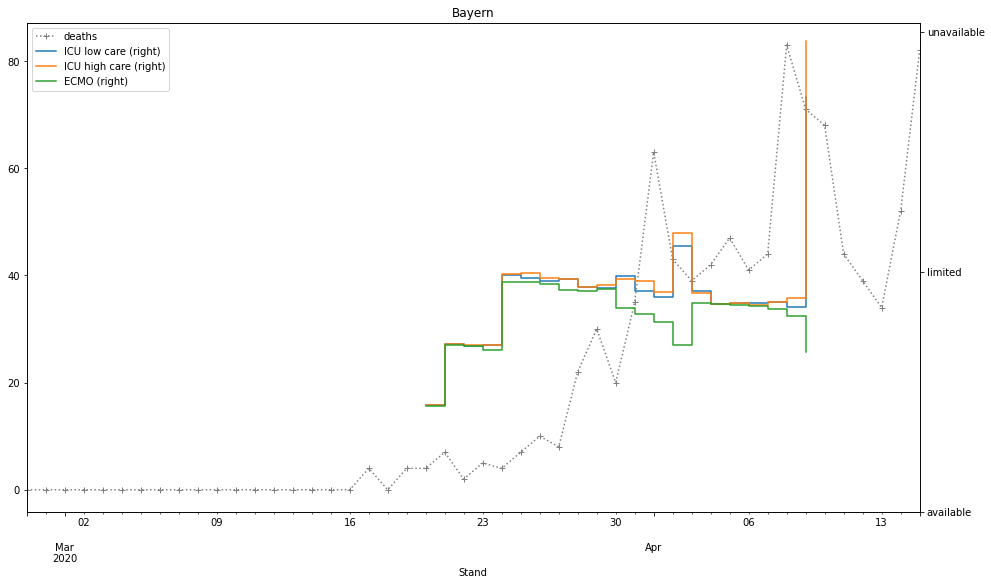

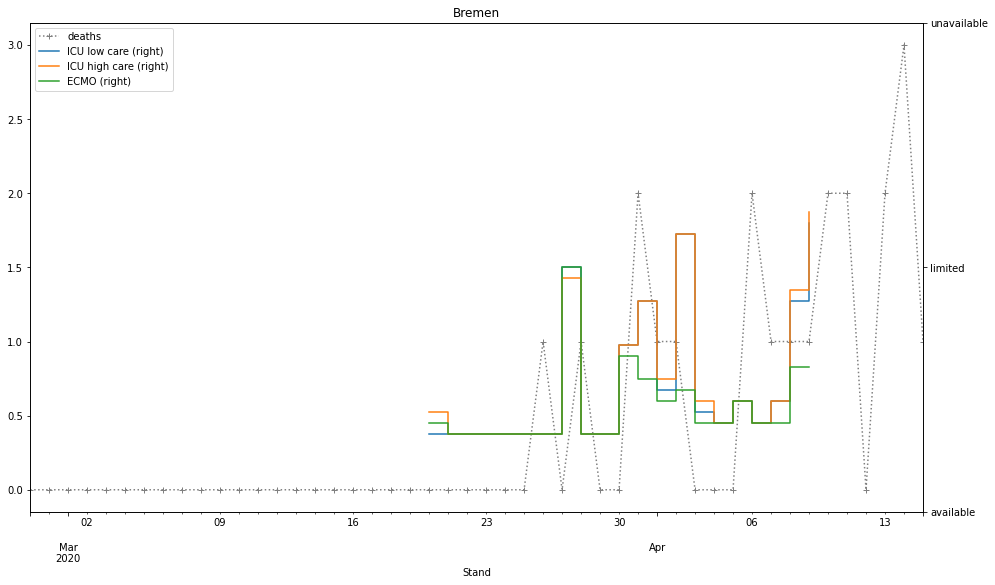

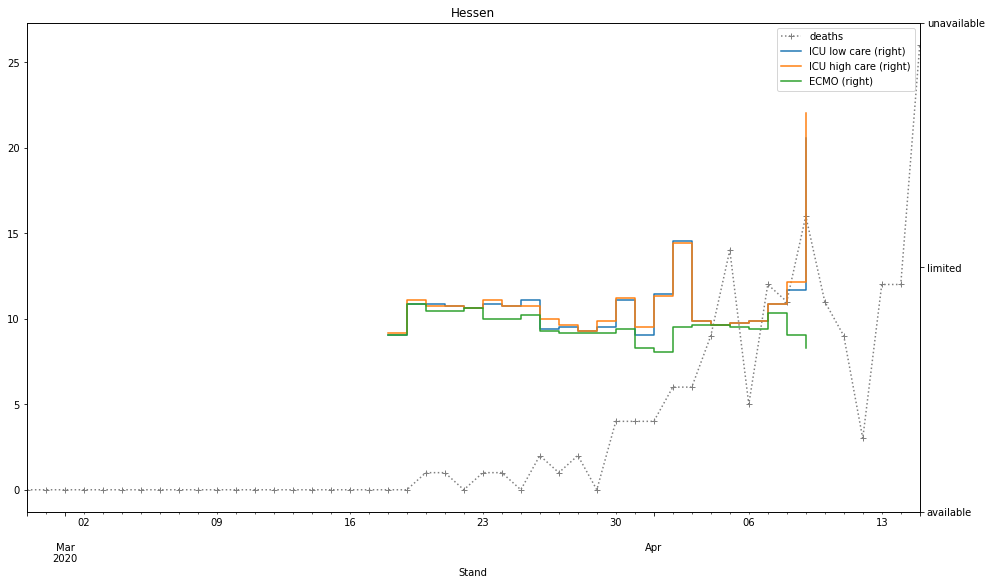

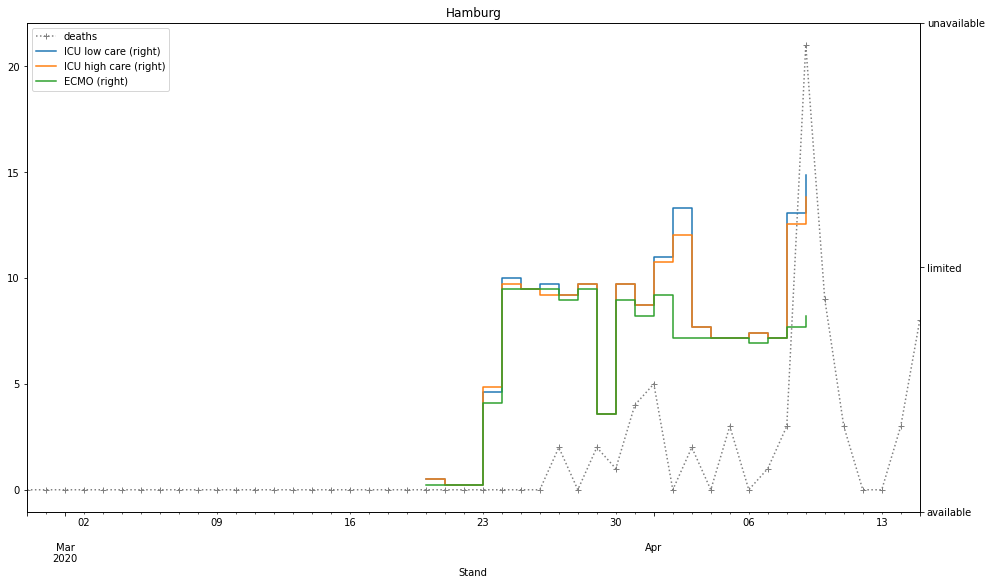

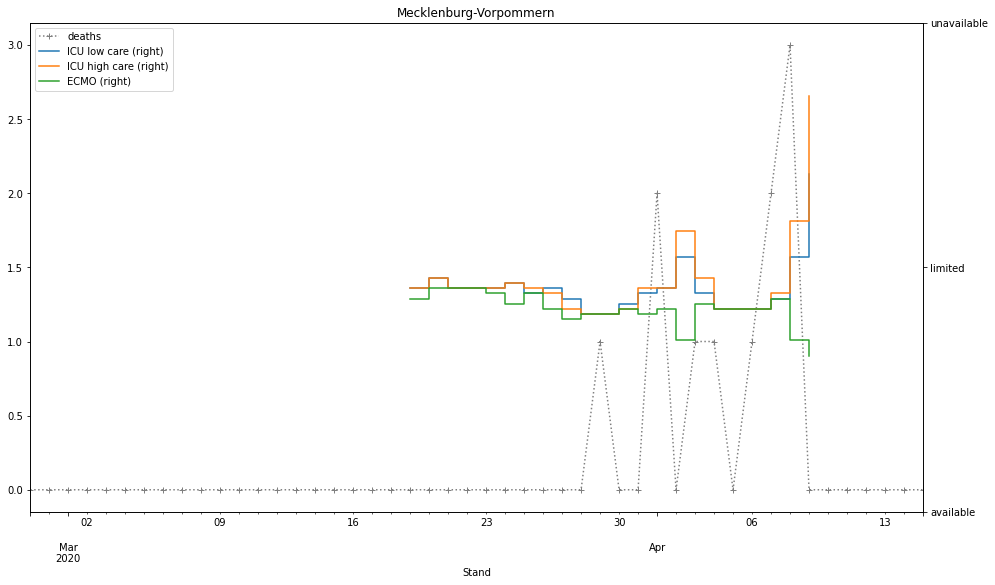

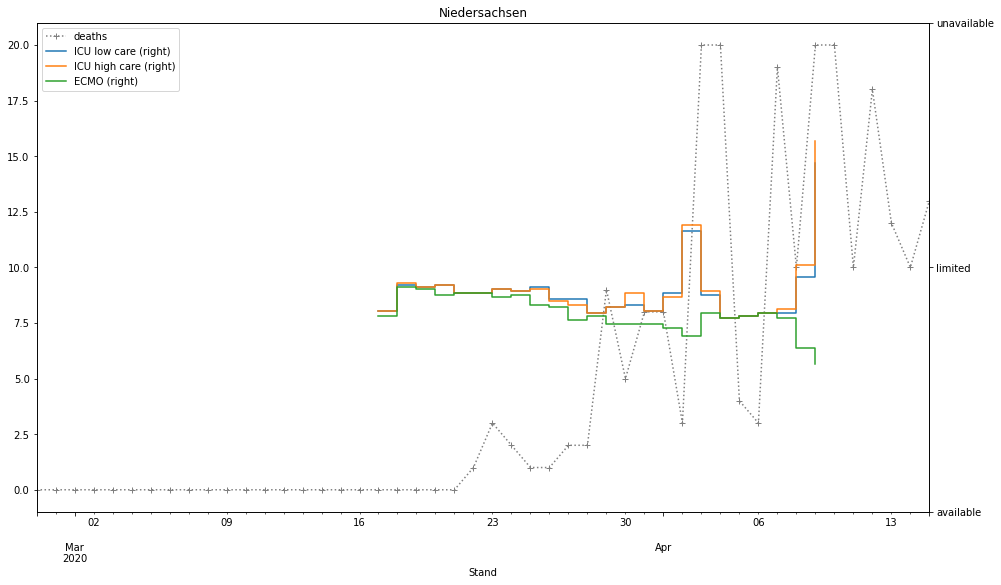

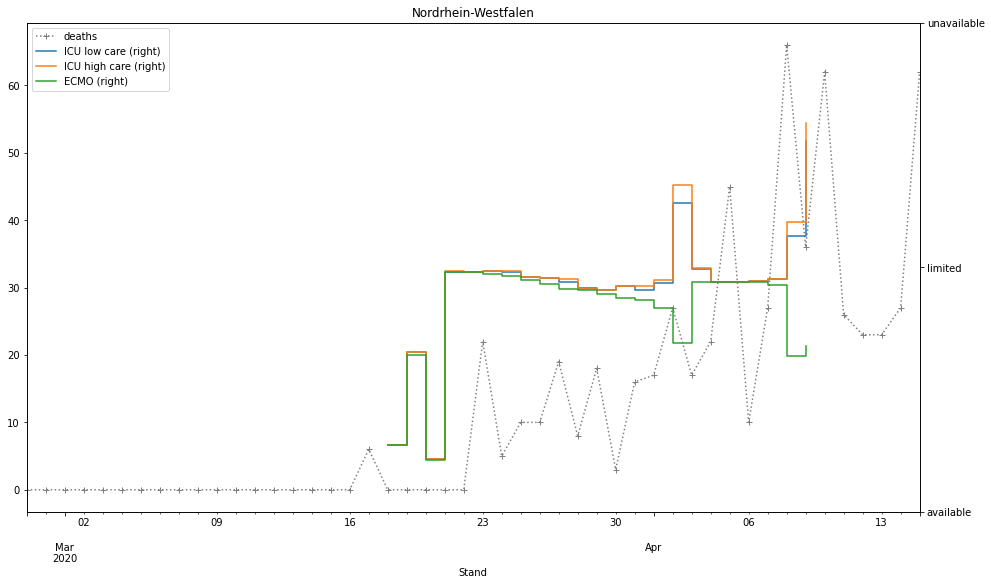

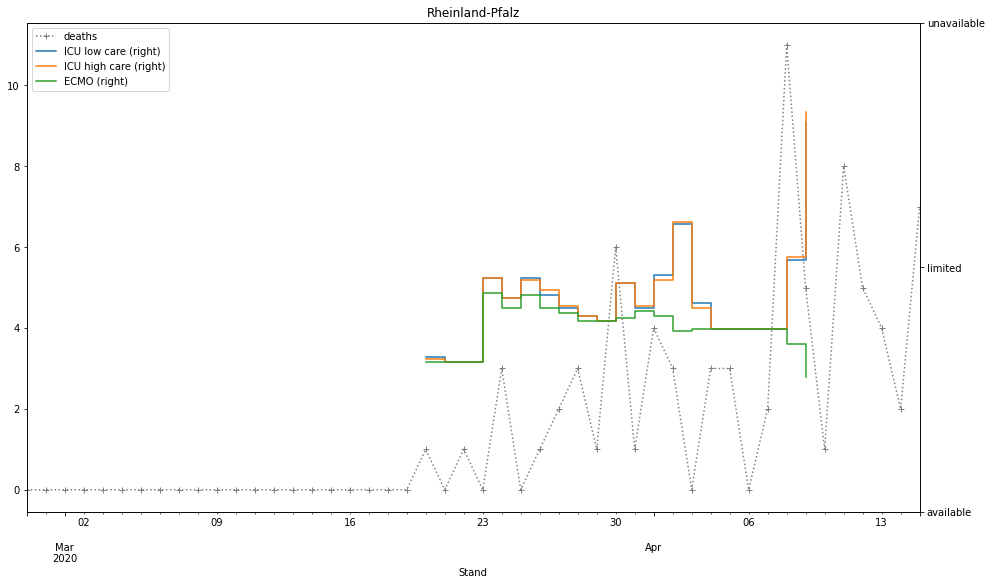

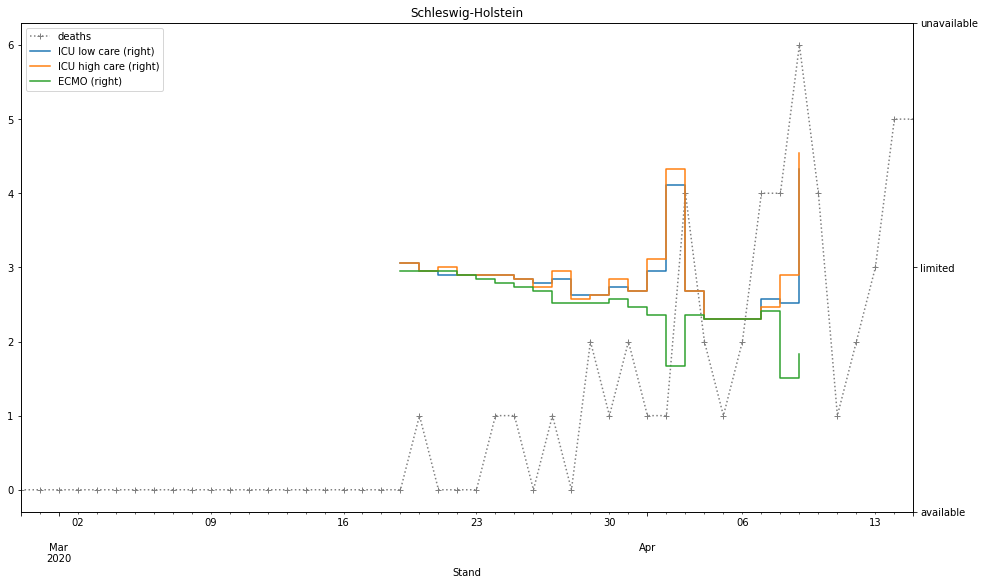

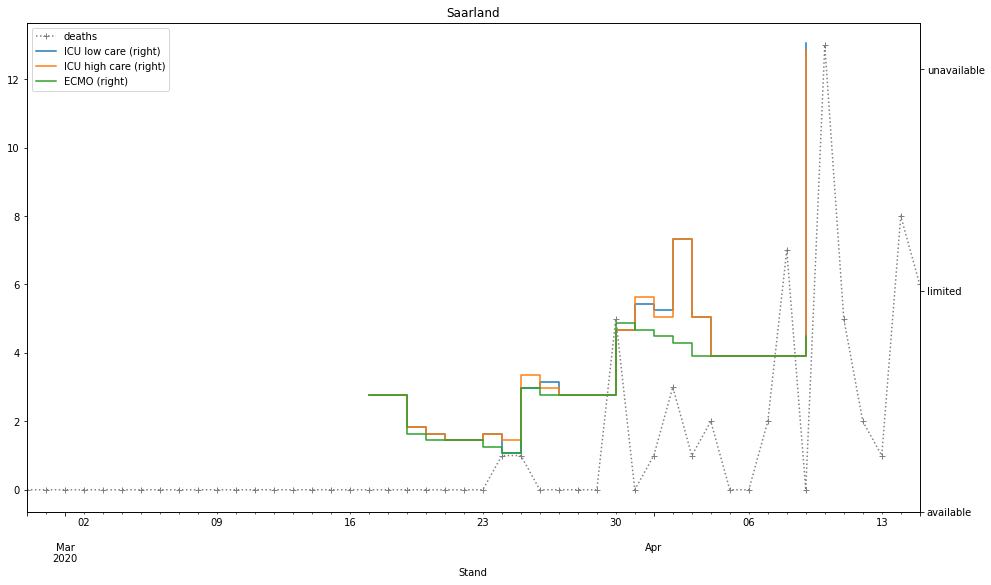

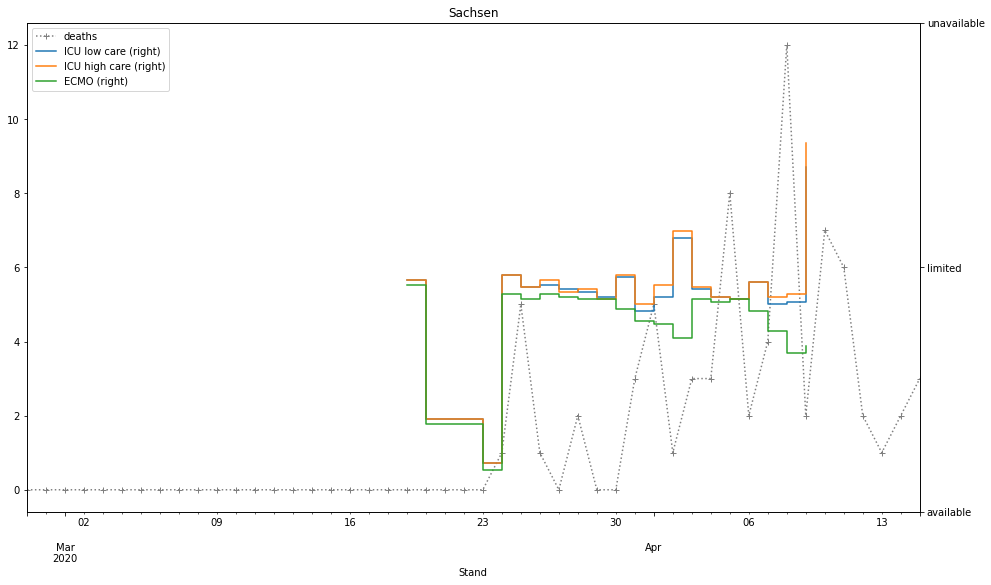

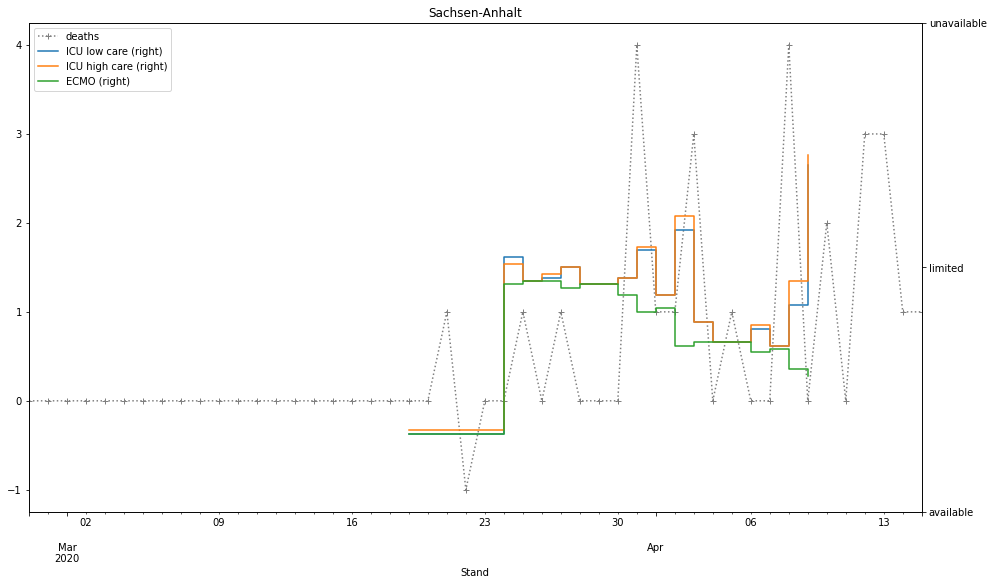

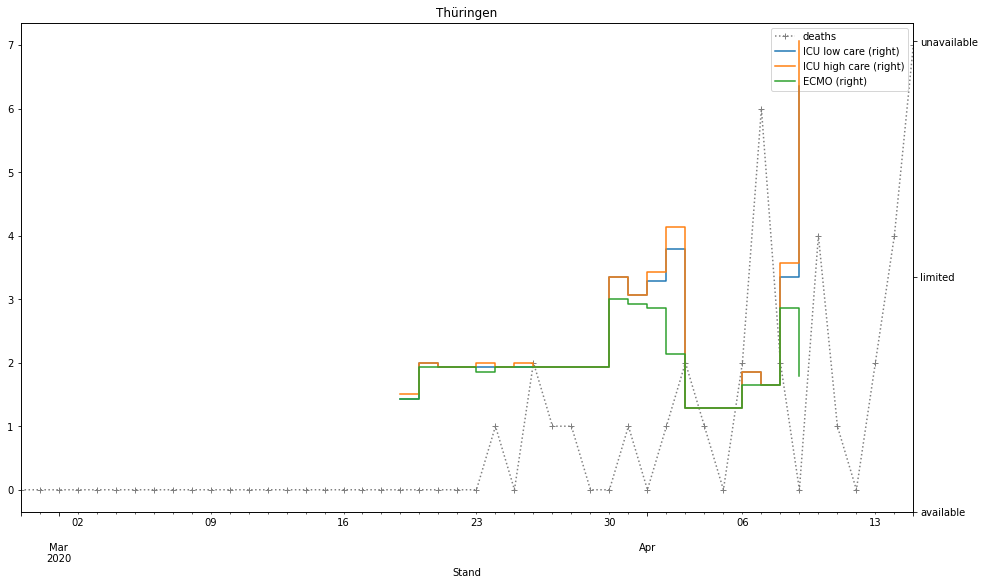

In [11]:
import matplotlib.dates as mdate

for federal_state in sorted(federal_states):
    fig, ax = plt.subplots()
    #infections[federal_state].plot(kind='line', ax=ax, secondary_y=True, color='red', linestyle='-', marker='')
    deaths[federal_state].plot(kind='line', ax=ax, color='grey', linestyle=':', marker='+', legend=True, figsize=(16,9))

    availability[federal_state].plot(kind='line', ax=ax, secondary_y=True, drawstyle='steps-post', marker='')
    plt.yticks([0.0 * num_clinics[federal_state],
                0.5 * num_clinics[federal_state],
                1.0 * num_clinics[federal_state]],
               ["available", "limited", "unavailable"])

    plt.title("%s" % federal_state_translation[federal_state])